# Module 3, Lab 1: Object Classification - Classical Techniques

This tutorial will give some visual intuition on how the classical object classification techniques work. 

The next tutorial will allow you to compare these techniques, which rely on hand-crafted features and smart algorithms, with their deep learning equivalents, where the features are *learned* by the network as a constituent part of training.

We are going to look at two different classical techniques from the perspective of performing inference only, not training. That is, we'll take pre-trained classifiers in both cases, and use them to classify images of various types.

Specifically:
* We will look at Viola-Jones, which is blazingly fast, but has obviously accuracy limitations;
* We'll also look at the Histogram of Oriented Gradients (HOG), which is more accurate but more computationally complex. 

Implementing either of them is outside the scope of this course, but we will look at how they work and leverage OpenCV's implementation of them for some practical demonstrations.

First, some setup...

In [1]:
# Load various libraries we'll need later in the tutorial...
import numpy as np
import cv2
%matplotlib inline
from matplotlib import pyplot as plt

/home/nbuser/anaconda3_420/lib/python3.5/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


# Viola-Jones and "Haar-like" Features

As you will have seen in our video lectures, Paul Viola and Michael Jones introduced the Viola-Jones technique for finding objects in images in 2001. It is a classical machine learning approach, where a cascade function is trained using a training set of positive and negative images.  For the purpose of explanation, let's assume we're looking for faces in a photo.

Viola-Jones has a number of important concepts, which we'll recap on:
 * Integral Images
 * Adaboost
 * Cascading

The Viola-Jones algorithm typically uses a base patch size (for example, 24x24 pixels) that it slides across and down an image. It evaluates a number of hand-crafted template features within each of these patches to see if the object of interest is present. The types of hand-crafted features (known as *Haar-like Features*) are shown as follows:

![Viola-Jones Features](images/VJ_features.png)

These features are equivalent to convolutional kernels. Each feature is evaluated to a single value by subtracting the sum of pixel intensities under the white rectangle from the sum of the pixel intensities under the black rectangle.  These sums of intensities can be computed extremely efficiently, and are responsible for much of the impressive speed of the Viola-Jones algorithm.

Viola-Jones uses a summed area table - essentially a cache of intensity values across an image. The summed area table has the same dimensions as the image of interest. For example, assuming our input image is 640 pixels wide, by 480 pixels high, by 3 channels (RGB), it will first be converted to grayscale (640x480x3 -> 640x480x1). Next, we will construct a summed area table of 640x480x1 where the value at each pixel location in the summed area table is the cumulative sum of itself and each pixel to the left and above it in the image.

![Viola-Jones summed area table calculation](images/ii.gif "Viola-Jones summed area table calculation" )

Once we have the summed area table, we can calculate the sum of intensity values over any arbitrary rectangular patch (an Integral Image) with 4 reads.  Assume that s(X) returns the summed table value for any point X. Now given points A, B, C, and D, then the Integral Image calculation for the rectangular patch defined by ABCD is defined as s(A) + s(D) - s(B) - s(C).

As we end up with more than 160,000 possible features for even a 24x24 patch, it is important to realise that not all features will be equally relevant for a particular type of object. Each feature (essentially a weak classifier) is considered good if it predicts better than chance the presence (or absence) of the desired object.  Viola-Jones uses an algorithm called **Adaboost** to perform *adaptive boosting* of the performance of the cascade of features through a number of iterative rounds. For more details, see our associated video with this module.  Picking the best small set of suitable features helps make the detector super fast. The original Viola-Jones paper achieved 95% accuracy with an appropriately chosen 6,000 feature subset from the 160,000 set of possible features.

However, having to run even 6,000 features on every patch would be a lot of effort. So, once the features have been decided and assembled, we build a cascade of fast rejectors. This is based on the intuition that over a complete image, most of the possible positions we check will not contain a face -- therefore it is faster overall to reject quickly than to invest too much in it. If the location doesn't contain a face, discard it and move on before investing more computational checks in it. This is another of the tricks used by Viola-Jones to achieve its performance. 

![Viola-Jones Cascade of Classifiers](images/VJ_cascade.png)

Instead of applying all 6,000 features on a window, we'll group these features into different stages of weak classifiers through the use of Adaboost, and we run these weak classifiers one-by-one in a *Cascade*. If the patch window under consideration fails at any stage, we reject the window and move onto the next patch. Only if a patch window passes one stage of the cascade do we consider moving onto the computation and evaluation of features on the next. A patch which passes all stages is considered a valid detection!

The classifier stages of the cascade are organised in order of increasing number of features, to ensure that early rejections are quick and cheap. In the Viola-Jones paper, the detector had approximately 6,000 features organised into 38 stages - but the first five stages had 1, 10, 25, 25, and 50 features in them respectively. On average, approximately 10 features need to be evaluated per patch in their testing.

Finally, a nice consequence of our features being so quick to calculate (thanks to the Integral Image) leads to the final aspect of Viola-Jones performance.  The base patch itself can be scaled and the features in the final cascade evaluated very quickly to search for objects of different sizes *without* the requirement for an image pyramid. 

(We'll cover the concept of an *image pyramid* in detail when we explore our next technique, the Histogram of Oriented Gradients, but in summary an image pyramid involves rescaling the original image multiple times.  You can think of each slightly smaller image as being stacked upon the previous one vertically, hence the pyramid. As we'll see, scanning across each of these scales repeatedly leads to significant computational cost and effort.)

Putting it all other, the Viola Jones workflow for training looks as follows:

![Viola-Jones - Training Flow](images/viola_jones_flow.png)

Let's run some code and see how well the Viola Jones algorithm works. To make it easy for you to experiment, we'll first load our test image into a variable... You can change this subsequently, and rerun the code to play with different images.


In [2]:
test_image = 'images/dev290x_presenters.jpg'

Let's load our image to see what it looks like.

We will convert our image to the RGB colorspace used by Jupyter Notebook before plotting, as OpenCV defaults to BGR.

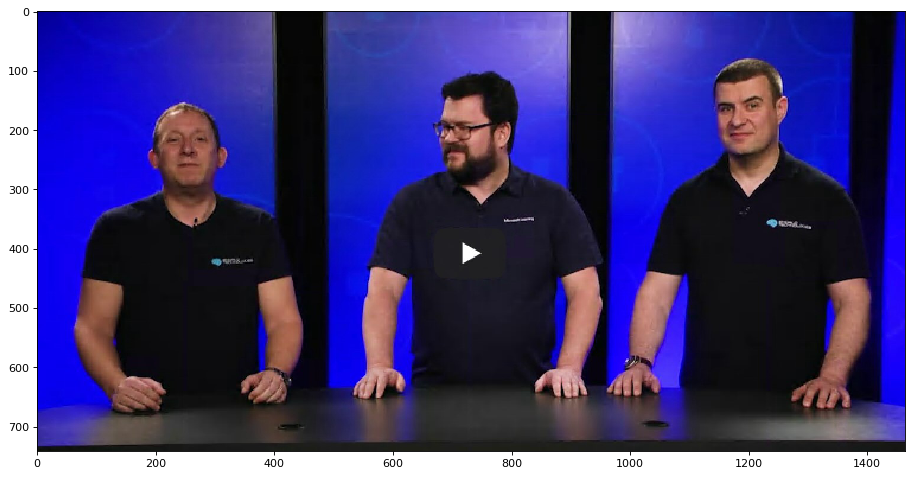

In [40]:
img = cv2.imread(test_image)

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(img)
plt.show()

Now, we'll create the cascades with default models that come with OpenCV - one for face detection, and one for eye detection.

These cascade files are XML files which represent the learned Viola-Jones classifier cascades, as described above.

In [41]:
# First, we load the cascades that come by default with OpenCV - one for face detection, and one for eye detection
# we'll find these relative to the CV2 library install

from os.path import realpath, normpath
cv2path = normpath(realpath(cv2.__file__) + '../../../../../share/OpenCV/haarcascades')

face_cascade_xml_path = cv2path + "/haarcascade_frontalface_default.xml"
eye_cascade_xml_path = cv2path + "/haarcascade_eye.xml"

face_cascade = cv2.CascadeClassifier(face_cascade_xml_path)
eye_cascade = cv2.CascadeClassifier(eye_cascade_xml_path)

# Now lets run the face detector cascade against this grayscale image
scale = 1.03
minNeighbors = 5 # It was 2
foundFaces = face_cascade.detectMultiScale(img, scale, minNeighbors)


The variable `foundFaces` will now contain an array of bounding boxes for each detected face. The number of items in `foundFaces` corresponds to the number of faces detected.
Each element in `foundFaces` is an array of x-position, y-position, width, and height for that particular bounding box.

In [42]:
print ("We found {}".format(len(foundFaces)) + " faces.")
print ("The array of bounding boxes [top_left_x, top_left_y, width, height] for each face are:\n{}".format(foundFaces))

We found 3 faces.
The array of bounding boxes [top_left_x, top_left_y, width, height] for each face are:
[[1122  112  127  127]
 [ 649  152  116  116]
 [ 195  171  119  119]]


Hopefully, we have now found all the faces in the image using the face detector cascade.  

Our next step is to draw bounding boxes around each of the faces. Then, for each face, we will search within it for eyes, and draw bounding boxes around the eyes in a different color.

In [43]:
# setup colors and line thickness for drawing bounding boxes
greenColor = (0, 255, 0)
blueColor = (255, 0, 0)
lineThickness = 2

detectionsImg = img
# now process each face found, 
for (fx, fy, fw, fh) in foundFaces:
    # draw the bounding box for each face
    cv2.rectangle(detectionsImg, (fx, fy), (fx + fw, fy + fh), blueColor, lineThickness)

    # next we'll run the eye detector cascade on the subset regions of the image (our
    # "regions of interest" (roi)) that were determined to contain faces...
    roi = detectionsImg[fy : fy + fh, fx : fx + fw]
    foundEyes = eye_cascade.detectMultiScale(roi, scale, minNeighbors)
    
    # now, lets draw bounding boxes for the eyes
    for (ex, ey, ew, eh) in foundEyes:
        cv2.rectangle(roi, (ex, ey), (ex + ew, ey + eh), greenColor, lineThickness)
        


Finally, lets show off our work by plotting these detections...

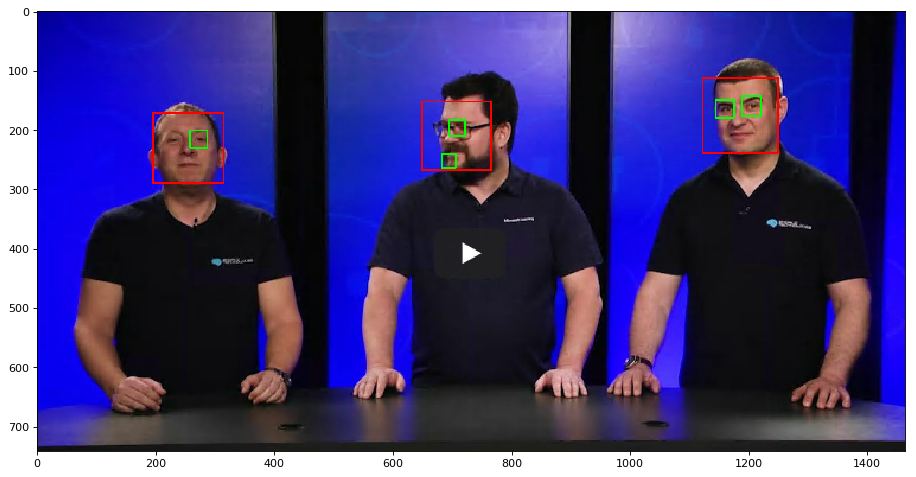

In [44]:
plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(img)
plt.show()

We can see that the detector is pretty good. It has managed to detect all the faces okay, 
but it seems to have found other patches in the image that are very definitely not faces.

Likewise, it has done an okay job at detecting eyes, but it has missed some and invented a few others.

The calls to method `detectMultiScale()` on the cascade objects do the work. `detectMultiScale()` takes three parameters of 
interest, plus some optional parameters that we'll ignore for this exercise.
The three parameters of interest are:
    
* **image**: the image matrix itself.
* **scale**: the scale stride value, indicating how much to resize the features after each run of the detector. 
* **minNeighbors**: a minimum neighbors field, which specifies how many neighbors each candidate detection should have to retain it. 
        
We are using default values of 1.03 for `scale`, and 2 for `minNeighbors`.

Try playing with these parameters yourself in the code above. For example, set `minNeighbors` to 1, 5, 10, and 100 respectively, rerun the code blocks above related to the Viola-Jones algorithm compare the difference in detections.


Both the scale and minimum neighbors parameters will affect the quality of the detection. Smaller scale values will cause the detector to check more scalings of the features against the image patch, but will increase the processing time. Likewise, larger values will cause fewer scalings which may result in loss of detections, but will run faster.

Setting minimum neighbors to a lower value will ensure that recall is good (no missed detections) but is likely to have many false positives. Setting minNeighbors to a higher value will improve precision (fewer false positives) but will degrade recall - i.e., there may be false negatives.

# Histogram of Oriented Gradients

Viola-Jones is a very fast detector, mostly because it leverages the Integral Image calculation, which allows it to check for faces at any scale really quickly.

The next algorithm we will ll look at is the HOG algorithm, which was a significant improvement over the state of the art when it was introduced in 2005 for pedestrian detection by Navneet Dalal and Bill Triggs. Variants of it continued to be used widely until approximately 2012 when AlexNet took the image classification world by storm.

A *Histogram of Oriented Gradients* (HOG) is a feature descriptor used in a variety of computer vision and image processing applications, for the purposes of object detection.  The use of HOG descriptors has been a particularly successful technique in detecting, among other things, humans, animals, faces, and text.  For example, an object detection system can be configured to generate HOG descriptors that describe features of objects in an input image.  The system can also be configured to compare the generated HOG descriptors against a database of HOG descriptors, corresponding to known objects, to determine whether any of the known objects is present in the input image.  

The reasons that HOG is used in these applications are that:

 * it offers robust detection of the object of interest in the presence of small amounts of rotation;
 * through the use of the image pyramid, it works for detecting objects at different scales;
 * thanks to some normalization within the construction of the feature descriptor itself, it works with variations in terms of lighting conditions etc.; and 
 * it generates a compact reference descriptor to be used to describe an object template for comparison with (HOG descriptors computed from) an incoming video-stream from a camera or other device.

Here are three related images that show HOG in operation: (a) the first is an image of a person (sample from the Inria training set), (b) the second is a visualization of that image when turned into HOG gradients and magnitudes (edges and strength of edges), and (c) the third is a visualization of the individual gradients normalized within each block, which improves the end classification score:


| ![](images/inria_pedestrian.png) | ![](images/inria_pedestrian_hog_normalized.png) | ![](images/inria_pedestrian_hog.png) |
|---------------------------|------------------------------------------|-------------------------------|
| (a) Pedestrian Image      | (b) HOG Gradients / Magnitudes           | (c) HOG Normalized per Block  |

The original image above is from the INRIA person database. 


## HOG Workflow

The general steps required to compute a HOG descriptor and convert to a classification score is called the "HOG Pipeline", as shown below.

![HOG Pipeline](images/HOG_Pipeline.png "HOG Pipeline")

The pipeline consists of the following steps:

 * **Gradient computation**:  A 1-D centred, point discrete derivative mask is applied in one or both of the horizontal and vertical directions, multiplying color or intensity data of image with the following filter kernels: [-1,0,1] and [-1,0,1]T .
 * **Orientation binning**: Bin pixel vote-weights into 9 histogram bins (covering 0 to 180 or 0 to 360 degrees). The weight, or pixel contribution, can either be the gradient magnitude itself, or some function of the magnitude; in actual tests the gradient magnitude itself generally produces the best results. Other options for the weight could include the square root or square of the gradient magnitude, or some clipped version of the magnitude.
 * **Descriptor blocks**: To account for changes in illumination and contrast, gradient strengths are locally normalized, by grouping cells  together into larger, spatially connected blocks. The HOG descriptor is then the vector of the components of the normalized cell histograms from all of the block regions. These blocks typically overlap, meaning that each cell contributes more than once to the final descriptor. Two main block geometries exist: rectangular R-HOG blocks and circular C-HOG blocks.  R-HOG blocks are generally square grids, represented by three parameters: the number of cells per block, the number of pixels per cell, and the number of channels per cell histogram and R-HOG blocks appear quite similar to the SIFT descriptors.  There is a minor improvement in performance by applying a Gaussian spatial window within each block before tabulating histogram votes.
 * **Block normalization**: there are a number of different algorithms typically applied to normalize histograms at the block level, including L2-norm, L2-Hysteresis, L1-Square Root, and L1-norm.
 * **Classifier** : The descriptors are finally fed into a recognition system based on a pre-trained classifier, most commonly a Support Vector Machine (SVM).
 
The entire process is illustrated as follows:

![HOG Feature Descriptor](images/HOG_Feature_Descriptor.png "HOG Feature Descriptor")

This HOG computation is traditionally performed by repeatedly stepping a window of, say, 64 pixels wide by 128 pixels high across a source image frame and computing the HOG descriptor as outlined in the previous section. As the HOG calculation contains no intrinsic sense of scale and objects can occur at multiple scales within an image, the HOG calculation is stepped and repeated across each level of a scale pyramid. The scaling factor between each level in the scale pyramid is commonly between 1.05 and 1.2 and the image is repeatedly down-scaled until the scaled source frame can no longer accommodate a complete HOG window as shown below.  

| ![HOG Image Pyramid](images/HOG_Image_Pyramid.png "HOG Image Pyramid") | ![Pyramid Scanning](images/Pyramid_Scanning.gif "Pyramid Scanning") |
|-----------------------------------------------------------------|----------------------------------------------------------------|
| HOG Image Pyramid                                               | Sliding Across Feature Descriptor then Resizing Image           |

Coarse spatial sampling, fine orientation sampling, and strong local photometric normalization permits the individual body movement of pedestrians to be ignored to a degree, so long as they maintain a roughly upright position.

### HOG Training

The first step of training is the creation, or acquisition, of a dataset, which consists of a number of positive and negative training example images.  Positive images are examples that contain the object we want to detect.  Ideally, the positives contain objects of approximately the same size and in approximately the center of the image, and across different illumination contexts, backgrounds, etc.  Partial occlusions may also be present in the positive training sub-set. Positive examples need to have the same dimensions as the feature detector.

The negative training set can be any images that do not contain the object we want to detect. In this respect, negative source images can be of any size, and patches the same size as the feature detector can be randomly sub-sampled across these images in spatial and scale space.

A commonly used training set for pedestrians is the INRIA Person Database, used by Dalal and Triggers for the original HOG implementation.  It can be downloaded from http://pascal.inrialpes.fr/data/human/. It consists of positive images in normalized 64x128 format, and negative images of larger sizes for sub-sampling. 

Typically, a portion of the dataset is reserved for testing the performance of the classifier afterwards – for example 10-20%.

![HOG Training Flow](images/hog_training_flow.png "HOG Training Flow")

The training process consists of the following steps, as illustrated above:

 * Generate a random set of negatives from the negative training images, across spatial and scale space. With the INRIA Person Database, for example, a set of 12180 examples (10 per negative image) might be randomly sampled.
 * Positive and negative source images are converted to HOG block descriptors.
 * These block descriptors are concatenated, converted into the input format for the SVM trainer and labelled appropriately as positive or negative.
 * The SVM trainer selects the best hyperplane to separate positive and negative examples from the training set, and an initial set of weights and a bias term are output.  As an example, the LIBSVM project (https://github.com/cjlin1/libsvm) includes a suitable trainer (svm-train) for learning and outputting this hyperplane.
 * The trainer typically outputs a set of “support vectors” (s) – that is, examples from the training set which best describe the hyperplane. The hyperplane is the learned decision boundary separating positive examples from negative examples. Each of these support vector includes a scale factor ("alpha", α).  
 * To calculate the hyperplane vector, v<sub>hyper</sub>, each support vector is scaled by its individual scaling factor, and the mean of this scaled set of support vectors is determined.
 
$$V_{hyper}=\ 1/n\sum_{i=1}^{n}{\alpha_i\ (s_i)}$$

Finally, the complete set of negatives in the training dataset is exhaustively searched for false positives – i.e. with those initial weights/bias, examples with a classification score greater than zero.  These negatives are added in as hard negatives to the training data, and training repeated. This process is called ‘boosting’ or ‘bootstrapping’.  Typically, 2-3 rounds of boosting are required to reach full performance.




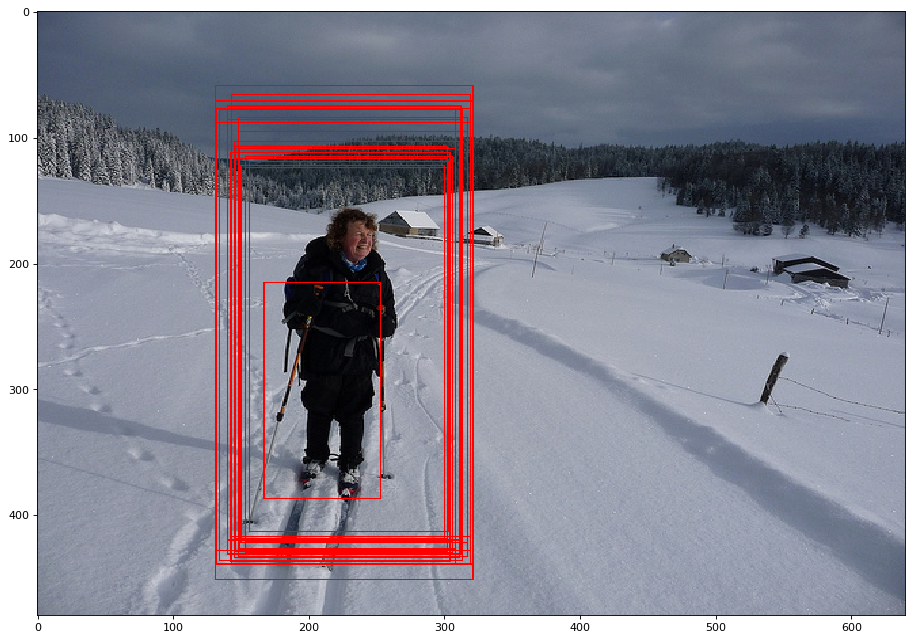

In [45]:
# read in test image (from Microsoft COCO database)
img = cv2.imread("images/000000002701.jpg")

# create HOG descriptor using default people (pedestrian) detector
hog = cv2.HOGDescriptor()
hog.setSVMDetector(cv2.HOGDescriptor_getDefaultPeopleDetector())

# run detection, using a spatial stride of 4 pixels (horizontal and verticle), a scale stride of 1.02, and zero grouping of
# rectangles (to demonstrate that HOG will detect at potentially multiple places in the scale pyramid)
(foundBoundingBoxes, weights) = hog.detectMultiScale(img, winStride=(4, 4), padding=(8, 8), scale=1.02, finalThreshold=0)

# we're going to copy the original test image to draw bounding boxes on it for now, as we'll use it again later
imgWithRawBboxes = img.copy()
for (hx, hy, hw, hh) in foundBoundingBoxes:
        cv2.rectangle(imgWithRawBboxes, (hx, hy), (hx + hw, hy + hh), (0, 0, 255), 1)
        
plt.figure(figsize=(14, 10), dpi=80)
imgWithRawBboxes = cv2.cvtColor(imgWithRawBboxes, cv2.COLOR_BGR2RGB)
plt.imshow(imgWithRawBboxes, aspect='auto') 
plt.show()


This illustrates some interesting properties and problems with HOG - you can see many extraneous detections which need to be fused together using non maximal suppression. Additionally, you can see many incorrect detections where the HOG algorithm incorrectly classified pedestrians.

In [46]:
# Let's install the imutils library which we'll use to do our NMS for us.
!pip install imutils

  Running setup.py bdist_wheel for imutils ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/4c/ff/aa/824fb9efc5b8c740d54cd8bc19c7e85fbb8d115c77e56812c7
Successfully built imutils


In [ ]:
from imutils.object_detection import non_max_suppression

# convert our bounding boxes from format (x1, y1, w, h) to (x1, y1, x2, y2)
rects = np.array([[x, y, x + w, y + h] for (x, y, w, h) in foundBoundingBoxes])

# run non-max suppression on these based on an overlay op 65%
nmsBoundingBoxes = non_max_suppression(rects, probs=None, overlapThresh=0.65)

print ("Before suppression, we had {} bounding boxes, after suppression we have {}".format(len(rects), len(nmsBoundingBoxes)))

# draw the final bounding boxes
for (xA, yA, xB, yB) in nmsBoundingBoxes:
    cv2.rectangle(img, (xA, yA), (xB, yB), greenColor, lineThickness)

# and show our work
plt.figure(figsize=(14, 10), dpi=80)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img, aspect='auto') 
plt.show()


Using the extra stage of non-maximal suppression on bounding boxes (based on percentage overlap), 
we have manage to consolidate our detections into a single reasonable detection...

# Conclusions

In this lab, we have seen two examples of traditional object classification/detection systems, using hand-crafted features with shallow learning algorithms.  We have learned about the image pyramid, and why it is sometimes needed to detect objects at different scales. We have also seen the need for non-maximal suppression of results during object detection.

With both Viola-Jones and HOG, the main problem is the lack of accuracy. 

Viola-Jones is very fast, and has found much use in detecting faces in images.

HOG is a more accurate detector. Its hand-crafted features detect gradients and gradient magnitudes for blocks of pixels, which is uses to learn characteristic sets of edges for a particular object detector.  However, it can be slow and often requires the use of a full image pyramid to perform detections at different scales.

For many years after its introduction, HOG and its derivative models represented the state of the art in object detection in terms of accuracy.

Over time, researchers incrementally improved the speed of HOG through caching, and the clever adoption of Haar ideas such as cascades of fast rejectors and scaling features not images. Others attempt to add higher semantic layers to HOG by breaking objects into constituent parts (*deformable parts models*) which had hand-crafted spatial relationships with each other. For example, for people detectors, this could include breaking up the person into a head, torso, arms and legs.

When CNNs were (re-)introduced to the problem of image classification with AlexNet in 2012, they were significantly more accurate than the best previous hand-crafted feature detector at the time, and they have continued improving at a faster rate.

In the next tutorial, we'll take a look at Microsoft's ResNet, which is a state of the art deep network for image classification.  We will also discuss the techniques deep nets are currently using to avoid requiring to scan the entire image pyramid, as we do above with the HOG example.
